# CLIMATOLOGIA - ATM

    "
    Last modified: 06/11/2021 - Júlia Mansur

    Created by: Júlia Mansur
    "


#### Packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, StrMethodFormatter
from matplotlib.pyplot import cm

import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import glob
import sys
import os

import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath("d:/Users/julia/Desktop/Academia/01_Mestrado/Work/Utils"))
from veldire2uv import *
from HistDir import *



In [223]:
def compute_histogram(variable, bin_max, bin_min, dbin, pdf=False):
    """ Computes 1D histogram or probability density for a given variable.
        
    Keyword arguments:
    variable -- 1D array.
    bin_max -- maximum value for bins
    bin_min -- minimum value for bins
    dbin -- bin size
    pdf -- (default False)
    
    Returns:
    bins -- histogram bins
    counts -- either counts or probability density
        
    """
    bins = np.arange(bin_min, bin_max, dbin)
    count = []
    for i in range(len(bins)):
        ind = (variable>bins[i] - dbin/2) & (variable<=bins[i]+dbin/2)
        count.append(ind.sum())
    count = np.array(count)
    if pdf:
        norm_hist = count/count.sum()/dbin
        assert np.allclose(norm_hist.sum()*dbin, 1.0), "PDF doesn't sum to 1"
    
        return bins, norm_hist
    else:
        return bins, count

#### Maps Settings

In [2]:
shp = 'D:/Users/julia/Desktop/Academia/01_Mestrado/Dados/Shapes/brasil_UF.shp'

extent = [-39.1,-33, -14.3,-4.3] # lonmin lonmax latmin latmax
proj = ccrs.PlateCarree()

# Importing Dataset

#### Read independent GRIB files and create combine NC

In [2]:
# # Get a list of all .nc files available in different folders
filenames = glob.glob("D:/Users/julia//Desktop/Academia/01_Mestrado/Dados/ERA5/*.grib")
dsmerged = xr.open_mfdataset(filenames,engine='cfgrib',backend_kwargs={'indexpath': ''})

# # Corrige erro de datas duplicadas pelo mfdataset
_, index = np.unique(dsmerged['time'], return_index=True)
dsmerged = dsmerged.isel(time=index)

dsmerged['t2m'] = dsmerged.t2m - 273
dsmerged.t2m.attrs['units'] = 'celsius'

dsmerged = dsmerged.drop(['step','surface','number','valid_time'])

In [ ]:
dsmerged.to_netcdf('../../Dados/ERA5.nc')

#### Read NC pre treated file

In [9]:
dsmerged = xr.open_dataset('D:/Users/julia//Desktop/Academia/01_Mestrado/Dados/ERA5.nc',)

------

            METAR
                      'label':['SBNT','SBJP','SBRF','SBMO','SBAR','SBSV'],

                      'Latitude':[-5.91,-7.15,-8.13,-9.51,-10.98,-12.91],

                      'Longitude': [-35.25,-34.97,-34.92,-35.79,-37.07,-38.33]

## Stations - WIND

In [13]:
era_SBNT = dsmerged.sel(latitude=-5.8, longitude=-35.1, method='nearest') # 2º point-5.8 -34.85
u_SBNT = era_SBNT['u10']
v_SBNT = era_SBNT['v10']

era_SBJP = dsmerged.sel(latitude=-7.05, longitude=-34.6, method='nearest') # 2º point-7.05 -34.35
u_SBJP = era_SBJP['u10']
v_SBJP = era_SBJP['v10']

era_SBRF = dsmerged.sel(latitude=-8.05, longitude=-34.6, method='nearest') # 2º point-8.05 -34.35
u_SBRF = era_SBRF['u10']
v_SBRF = era_SBRF['v10']

era_SBMO = dsmerged.sel(latitude=-9.55, longitude=-35.35, method='nearest') # 2º point-9.55 -35.1
u_SBMO = era_SBMO['u10']
v_SBMO = era_SBMO['v10']

era_SBAR = dsmerged.sel(latitude=-11.05, longitude=-36.85, method='nearest') # 2º point -11.05 -36.6
u_SBAR = era_SBAR['u10']
v_SBAR = era_SBAR['v10']

era_SBSV = dsmerged.sel(latitude=-13.05, longitude=-38.35, method='nearest') # 2º point -12.8 -37.85/-38.1
u_SBSV = era_SBSV['u10']
v_SBSV = era_SBSV['v10']

### Serie Temporal - 2017/2018

In [236]:
era = [era_SBNT,era_SBJP,era_SBRF,era_SBMO,era_SBAR,era_SBSV]
Coast_angle_Corr = [-15,0,20,40,40,45] # correção para estação de salvador baseado na literatura, nao no grau calculado 
names = ['SBNT','SBJP','SBRF','SBMO','SBAR','SBSV']     

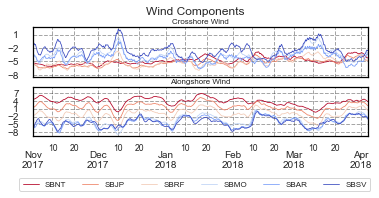

In [293]:
periods = [122,97,85,71,63,53]

fig, [ax,ax2] = plt.subplots(2,1, sharex=True,gridspec_kw={'width_ratios': [3]}) 
fig.subplots_adjust(bottom=.5,wspace=0.015)
fig.suptitle('Wind Components',fontsize=12,y=.95)
color=cm.coolwarm_r(np.linspace(0,1,6))

for e,cor,n,p,c in zip(era,Coast_angle_Corr,names,periods,color):

        e = e.sel(time=slice('2017-10-15', '2018-04-16'))
        e = e.assign(vel=lambda e: np.sqrt(e['u10']**2+e['v10']**2))
        e = e.assign(dire=lambda e: (np.mod(180+np.rad2deg(np.arctan2(e['u10'], e['v10'])),360)) - cor)
        e.dire[e.dire<0] += 360

        u,v = veldire2uv(e.vel,e.dire,par='wnd')

        u_MA = pd.Series(u).rolling(window=p,center=True).mean()
        v_MA = pd.Series(v).rolling(window=p,center=True).mean()

        # FIGURA
        ax.plot(u.time,u_MA, linewidth=.8, c=c)
        ax2.plot(v.time,v_MA, linewidth=.8, c=c)
        
ax.set_title('Crosshore Wind',fontsize=8,y=.95)
ax.tick_params(which='major', labelsize=10, length=10, pad=4.2, labelrotation=0,)
ax2.set_title('Alongshore Wind',fontsize=8,y=.95)
ax2.tick_params(which='major', labelsize=10, length=10, pad=4.2, labelrotation=0,)

ax.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=(11,12,1,2,3,4)))
ax.xaxis.set_minor_locator(
        mdates.DayLocator(bymonthday=(10,20)))
ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax2.tick_params(which='minor', width=1.0, labelsize=8.5)

ax.set_yticks(np.arange(-8,3,3))
ax2.set_yticks(np.arange(-8,8,3))
ax.set_xlim(17471,17625)

ax2.legend(labels=names,bbox_to_anchor=(1.02,-0.75),ncol=6,fontsize=8)

for a in fig.axes:
        a.grid(linestyle='--',alpha=0.35,which='both')
        # a.set_ylim(-7,7)
        # a.set_yticklabel(fontsize=8)


plt.savefig('D:/Users/julia/Desktop/Academia/01_Mestrado/Resultados/U-V.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
                       

## Hist Scat

In [ ]:
dbin = .2

for e,cor,n in zip(era,Coast_angle_Corr,names):
    
    b_sst, n_sst = compute_histogram(sst.analysed_sst,bin_max=sst.analysed_sst.max(),bin_min=sst.analysed_sst.min(), dbin=dbin, pdf=True)
    b_sub, n_sub = compute_histogram(sub.thetao,bin_max=sub.thetao.max(),bin_min=sub.thetao.min(), dbin=dbin, pdf=True)
    
    print(s)
    cf = np.round(np.corrcoef(sst.analysed_sst,sub.thetao)[1][0],4)

    fig, [ax1,ax2] = plt.subplots(1,2)
    fig.subplots_adjust(bottom=0.5,wspace=0.3)

    ax1.plot(b_sst, n_sst, 'goldenrod',  lw=2, label='MUR (sst)')
    ax1.plot(b_sub, n_sub, 'darkred', lw=2, label='Merc. (0.45m)')
    ax1.set_xlim(24,30)
    ax1.set_ylim(0,1)
    ax1.legend(fontsize=8, bbox_to_anchor = (-.1,-.18),loc='upper left', ncol=2)
    ax1.set_ylabel('Probability density',  fontsize=10)
    ax1.set_xlabel('Temp. (°C)')
    ax1.grid(linestyle='--',alpha=0.7,which='both')
    ax1.set_aspect('auto')

    ax2.scatter(sub.thetao,sst.analysed_sst,color='darkblue',alpha=.7)
    ax2.grid(linestyle='--',alpha=0.7,which='both')
    ax2.set_xlabel('Temp. (°C)', fontsize=10)
    ax2.set_ylabel('Temp. (°C)', fontsize=10)
    ax2.set_ylim(24,30)
    ax2.set_yticks([24,26,28,30])
    ax2.set_xlim(24,30)
    ax2.set_xticks([24,26,28,30])
    ax2.set_aspect('equal')

    fig.subplots_adjust(bottom=0.25)


    ax2.annotate('Coef. Corr.:', fontsize=6,color='k',xy=(.7,.1),xycoords='axes fraction')              
    ax2.annotate("$r^2$ = " + str(cf), fontsize=6,color='darkblue',
                xy=(.7, .05), xycoords='axes fraction',)

    fig.suptitle(t,fontsize=12,y=1.01)

    plt.savefig('D:/Users/julia/Desktop/Academia/01_Mestrado/Resultados/superficie_'+s+'.png', format='png', dpi=300, bbox_inches='tight')

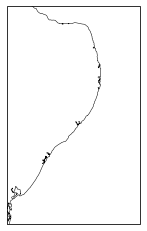

In [66]:
# plt.imshow(dsmerged.t2m[0])
# plt.ion()
# plt.axes.coastlines( linewidth=0.3, color='#778899')  

fig = plt.figure()  
ax = plt.axes(projection= proj)  
ax.set_extent(extent)  
ax.coastlines( linewidth=0.5, color='k') 

ax.plot(dsmerged.t2m[0])


#### Maps Settings

In [ ]:
shp = 'D:/Users/julia/Desktop/Academia/01_Mestrado/Dados/Shapes/brasil_UF.shp'

extent = [-39.1,-33, -14.3,-4.3] # lonmin lonmax latmin latmax
proj = ccrs.PlateCarree()

In [ ]:
ds=xr.open_dataset('D:/Users/julia//Desktop/Academia/01_Mestrado/Dados/ERA5/2019.grib',engine='cfgrib',backend_kwargs={'indexpath': ''})

In [ ]:
t = ds.t2m.sel(latitude=-12.7,longitude=-37.92,method='nearest')
t = t - 273
t.attrs['units'] = 'celsius'
t = t.resample(time='1D').mean()


In [67]:
dsmerged

<xarray.Dataset>
Dimensions:    (time: 157776, latitude: 41, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 ... 2019-12-31T23:00:00
  * latitude   (latitude) float64 -4.3 -4.55 -4.8 -5.05 ... -13.8 -14.05 -14.3
  * longitude  (longitude) float64 -39.1 -38.85 -38.6 ... -33.6 -33.35 -33.1
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 41, 25), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 41, 25), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 41, 25), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 41, 25), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 41, 25), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 41, 25), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-06T15:53 GRIB to CDM+CF via cfgrib-0.9.9...

In [ ]:
fig, ax = plt.subplots(1,1)

plt.imshow(ds.t2m[0],cmap='magma')
shape_feature = ShapelyFeature(Reader(shp).geometries(),
                                        ccrs.PlateCarree(), edgecolor='gray',linewidth=.5)
# gl = ax.gridlines(crs=proj, draw_labels=True,
#                     linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl.xlocator = mticker.FixedLocator(np.arange(-35,-39.5,-1.5))
# gl.ylocator = mticker.FixedLocator(np.arange(-5,-14.5,-2.5)) 
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# plt.rcParams.update({'font.size': 10})

# ax.add_feature(shape_feature,facecolor='oldlace')

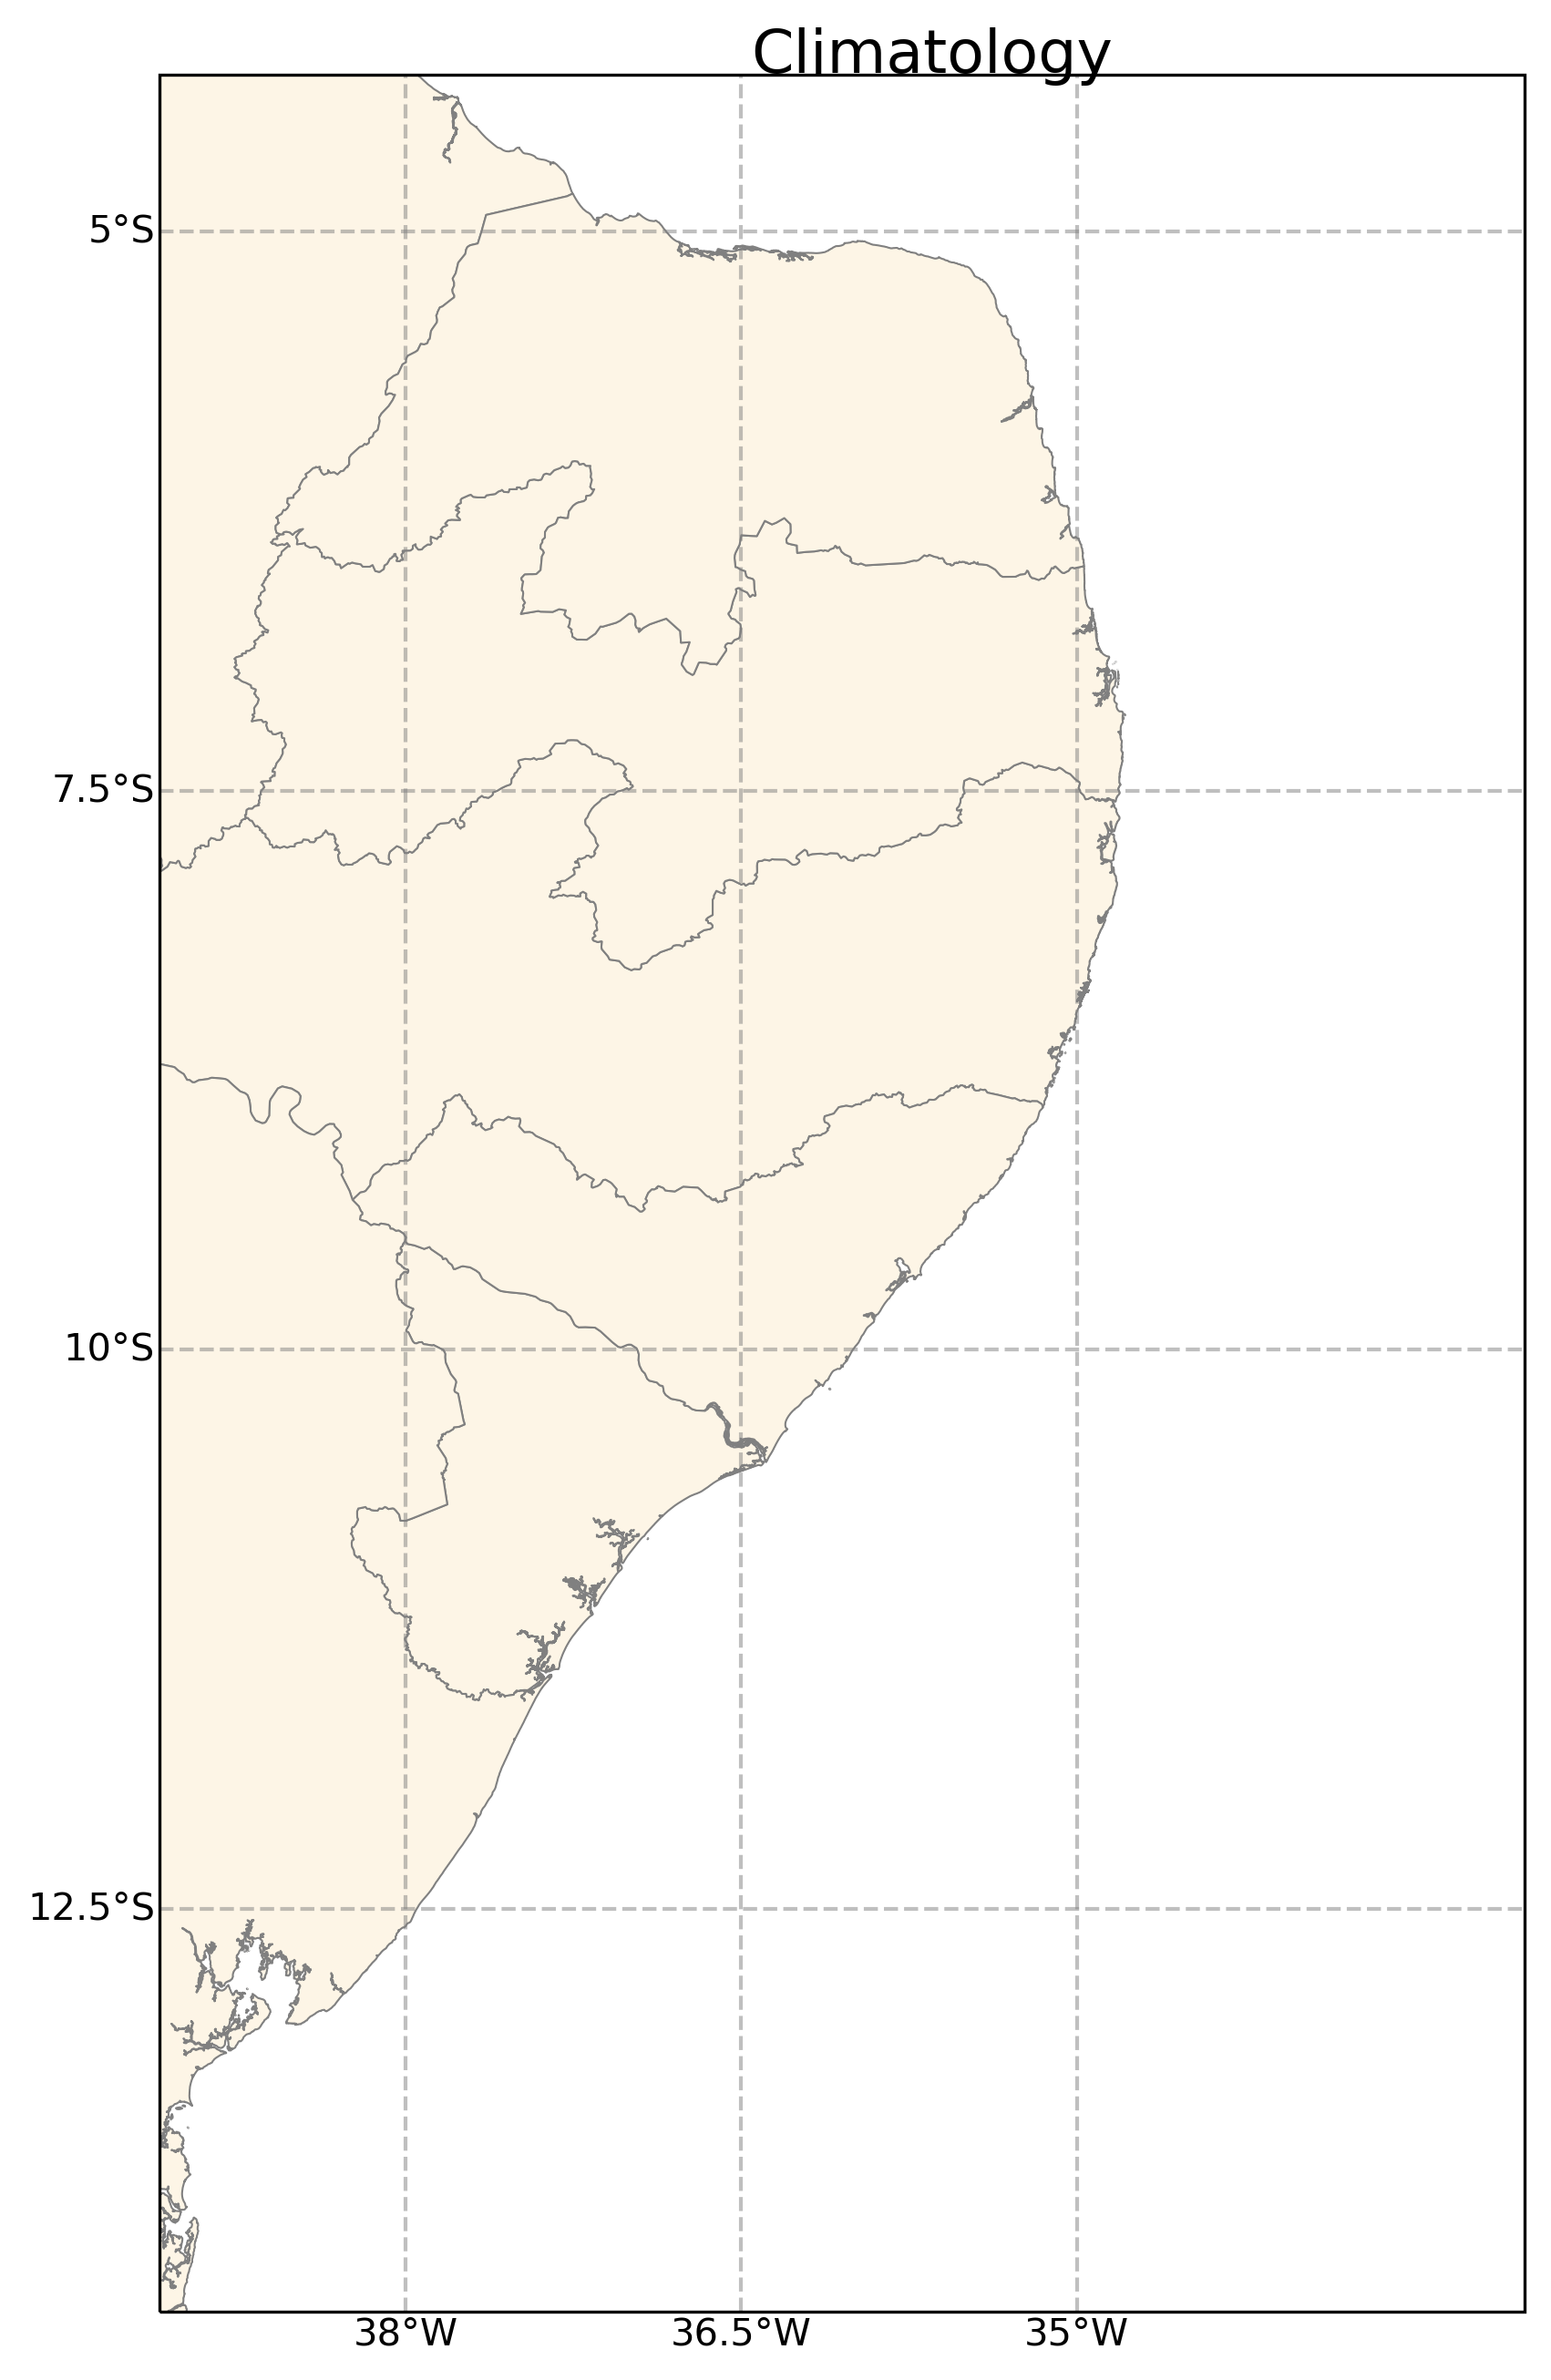

In [31]:
fig = plt.figure(figsize=(16.53,11.69), dpi = 300, tight_layout=True)
fig.suptitle('Climatology', fontsize=16, y=0.815)
fig.subplots_adjust(left=None, bottom=0.1, right=0.835, top=.8, wspace=0.1, hspace=0.005)
fig.patch.set_facecolor('white')

ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent(extent)
gl = ax.gridlines(crs=proj, draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-35,-39.5,-1.5))
gl.ylocator = mticker.FixedLocator(np.arange(-5,-14.5,-2.5)) 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.rcParams.update({'font.size': 10})

shape_feature = ShapelyFeature(Reader(shp).geometries(),
                                    ccrs.PlateCarree(), edgecolor='gray',linewidth=.5)
ax.add_feature(shape_feature,facecolor='oldlace')

# im = dsmerged.t2m.plot(ax=ax, transform=proj, vmin=20, vmax=32,
#                  cmap='RdBu_r', add_colorbar=False,)

plt.imshow(dsmerged.t2m[0],cmap='magma')

In [ ]:
fig = plt.figure(figsize=(16.53,11.69), dpi = 300, tight_layout=True) # open a new figure window and set the resolution
fig.suptitle('Climatology - SST', fontsize=16, y=0.815)
fig.subplots_adjust(left=None, bottom=0.1, right=0.835, top=.8, wspace=0.1, hspace=0.005)
fig.patch.set_facecolor('white')

for n,m in enumerate(Months):
    if n>0:
        print('Done: '+ Months_names[n-1])
    
    print('Processing: ' + Months_names[n])
    
    cc = Month_climatology.analysed_sst.sel(month=m)
    del cc['month']
    
    ax = plt.subplot(2, 6, n+1, projection=proj)
    ax.set_extent(extent)
    ax.text(0.9, 0.02, Months_names[n], fontweight='bold', fontsize=12, transform=ax.transAxes, ha="right",)

    
    gl = ax.gridlines(crs=proj, draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-35,-39.5,-1.5))
    gl.ylocator = mticker.FixedLocator(np.arange(-5,-14.5,-2.5)) 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.rcParams.update({'font.size': 10})

    if n != 0 and n != 6:
        gl.ylabels_left = False
    
    if n < 6:
        gl.xlabels_bottom = False
    

    shape_feature = ShapelyFeature(Reader(shp).geometries(),
                                    ccrs.PlateCarree(), edgecolor='gray',linewidth=.5)
    ax.add_feature(shape_feature,facecolor='oldlace')

    im = cc.plot(ax=ax, transform=proj, vmin=Tmin, vmax=Tmax,
                 cmap='RdBu_r', add_colorbar=False,)
    
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="vertical",) #shrink=.8
cbar.set_label(label='Temp. (°C)', size=12)
cbar.ax.tick_params(labelsize=12)

print('Done: '+ Months_names[n])
    
# plt.savefig('D:/Users/julia/Desktop/Academia/01_Mestrado/Resultados/MUR/Figuras/Climatologia/SST-Clim_Mensal_v'+ str(Versao) + '.png',
#             bbox_inches='tight') # Save image as PNG file without large white borders

print('Picture: Saved')
plt.close()
# plt.show()